In [1]:
import gc
import math
import itertools

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

import scipy.stats as st
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion

from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture, BayesianGaussianMixture
from sklearn.cluster import KMeans, MeanShift, estimate_bandwidth, DBSCAN, OPTICS

import infoStructure as ins
import helpers as hp
import clustering as cl
import display as dp
import importlib #importlib.reload(foo)

> Point to the directories (output for the processed mat files and where the mat files reside

In [74]:
INPUTDir = '/media/valeporti/ADATA SH14/stg/Brest/' # the directory where the all the patients are (RS1000, RS10001...)
OUTPUTDir = '/media/valeporti/ADATA SH14/stg/'
# also, the variables to get from .mat files used all along the study
titles = ['vectorRRKLD', 'vectorFAmpKLD', 'vectorUFAmpKLD', 'vectorCorrKLD'] 
feat_dict = None
df_ALL = None

> Grab all the patients directory that you need, and the specific features from the 34

<span style="color:red">Just needed to extract information. If needed, remove the tripple quotes</span>
```python
""" commented code """
```

In [ ]:
importlib.reload(ins)
importlib.reload(hp)
quantities = [5, 10, 50, 100, 200]#[10, 50, 100, 200] # max num of patients = 524
## randomly
ins.addAllPatientsInfoV4(INPUTDir, titles, quantities, OUTPUTDir, to_hdf=True)

## in order, starting from N # of directory, qty = number of directories
#qty = 10
#start_from = 0
#feat_dict = ins.addAllPatientsInfoV3(INPUTDir, titles, qty, start_from)

Working on RS10197 #0
Working on RS10185 #1
Working on RS10116 #2
Working on RS10125 #3
Working on RS10206 #4
Working on RS10234 #5
Working on RS10111 #6
Working on RS10277 #7
Working on RS10361 #8
Working on RS10459 #9
Working on RS10080 #10
Working on RS10136 #11
Working on RS10285 #12
Working on RS10269 #13
Working on RS10379 #14
Working on RS10218 #15
Working on RS10283 #16
Working on RS10208 #17
Working on RS10344 #18
Working on RS10242 #19
Working on RS10358 #20
Working on RS10175 #21
Working on RS10244 #22
Working on RS10431 #23
Working on RS10364 #24
Working on RS10236 #25
Working on RS10349 #26
Working on RS10189 #27
Working on RS10148 #28
Working on RS10050 #29
Working on RS10329 #30
Working on RS10144 #31
Working on RS10306 #32
Working on RS10003 #33
Working on RS10024 #34
Working on RS10196 #35
Working on RS10091 #36
Working on RS10051 #37
Working on RS10207 #38
Working on RS10429 #39
Working on RS10258 #40
Working on RS10278 #41
Working on RS10433 #42
Working on RS10387 #4

** Grab the information previously treated and saved as a feather file **

In [64]:
importlib.reload(hp)
name_of_file = '3_f32.h5' #'550_32.feather'
# if the information has been grabed from previous cell (from patients input files)
#df_ALL = hp.convertDictInDF(feat_dict)
df_ALL = hp.readFileToPandas(OUTPUTDir + name_of_file)
df_ALL.info()

reading h5
<class 'pandas.core.frame.DataFrame'>
Int64Index: 592470 entries, 0 to 166164
Data columns (total 6 columns):
vectorRRKLD       592460 non-null float32
voie_num          592470 non-null uint8
vectorFAmpKLD     592470 non-null float32
vectorUFAmpKLD    592470 non-null float32
vectorCorrKLD     592470 non-null float32
paths             592470 non-null object
dtypes: float32(4), object(1), uint8(1)
memory usage: 18.6+ MB


In [69]:
df_ALL.shape

(592470, 6)

** According to the quantity of the memory available, grab randomly the rows for the study of the data **
> 0.22 (22%) for a 16Go RAM memory avaliable computer, for one model

> 0.16 for a 16Go RAM memory available computer, for running several models (like GMM but several times to get the best BIC score)

In [66]:
df_DIV, indexes = hp.getRandomRows(df_ALL, 0.5)
df_DIV, df_info = hp.cleanDF(df_DIV, ['paths', 'voie_num']) # divide DF between pure info and data

### Preprocessing

In [21]:
df_DIV = cl.cleanData(df_DIV, 'mean') # impute non available data in the columns using a strategy (mean, median, most_frequent)

> Dependign if PCA wants to be applied, run one or the other, in this step, removing outliers and normalization takes place

> Besides, in order to do a hard removal for the difficult "vectorUFAmpKLD" feature removal, choose v3=True for the runOutNormV2, else, if just wanted it to be handled with the meanshift appraoch, use v3=False

In [8]:
df_nout, Xnorm, std, indexes2 = cl.runOutNormV2(df_DIV, indexes, threshold=20, threshold_hard=0.01, v3=True)
## for PCA run this one
#df_nout, Xnorm, Xpca, dfPca, titPca, pca, std, indexes2 = cl.runOutNormPCAV2(df_DIV, indexes, threshold=20, threshold_hard=0.01, cols_hard=[0,2])

bandwidth: 109.7043499450144
number of estimated clusters : 384
shapes: (914928,), (914928, 4)
shapes: (888766,), (888766, 4)
to_maintain_indexes  [False  True False ...  True  True  True]
after hard removal (vectorUFAmpKLD && vectorRRKLD) shape : (838182, 4) && 91.61
after soft removal (vectorCorrKLD && vectorFAmpKLD) shape : (888766, 4) && 97.14


> declare which matrix of data should be used for the models according to the previous choice

In [9]:
X = Xnorm # Xnorm or Xpca

> print data as obtained from preprocessing, 
 ```python
if Xpca, the "titPca" variable should be passed,
else titles of columns should be passed (['vectorRRKLD', 'vectorFAmpKLD', 'vectorUFAmpKLD', 'vectorCorrKLD'])
```

In [11]:
#dp.printPCAScatter(df_nout, titles)
del df_nout; gc.collect()
# del dfPca; gc.collect()

0

### Model

```python 
if used v3=False for the preprorcessing step (runOutNormV2 function), components should be around 8 and 10
else components are around 6 and 8
```

In [12]:
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange', 'gold', 'tomato', 'crimson', 'darkslategray', 'springgreen', 'chocolate'])

In [13]:
gmm = GaussianMixture(n_components=7, covariance_type='full', random_state=0).fit(X)
#gmm10 = GaussianMixture(n_components=10, covariance_type='full').fit(X)

> ** TO PRINT**

```python
# for 2d prinring of all clusters together (6 images), use: 
dp.printPCAGMM(gmm_to_print, X, titles, color_iter)
# for 2d printing of one cluster, use next: 
# ( gmm, gmm.predict(X), cluster #, column_1_to_display, column_2_to_display, color_of_cluster, titles )
fig, ax = plt.subplots(1, 1)
dp.plotOneGMMCluster(ax, X, predicted, 0, 0, 1, 'turquoise', titles)
# for 3d printing of onw cluster, use next: 
# ( 3dfig, gmm, gmm.predict(X), cluster #, column_1_to_display, column_2_to_display, column_3_to_display, color_of_cluster, titles)
ax = plt.axes(projection='3d') # just once!!
dp.plotOneGMMCluster3D(ax, X, predicted, 2, 0, 1, 2, 'turquoise', titles)
# to print all 6 possible combinations 
dp.plotAll2DGMMs(X, predicted, 1, 'turquoise', titles)
```

> <span style="color:red">put one plot by cell, if not, dynamic display wont appear for each plot</span>

In [14]:
gmm_to_print = gmm
predicted = gmm_to_print.predict(X)
print(hp.getRepresentativeness(gmm_to_print, X, predicted))

{'>50': 1, '>30': 0, '>15': 1, '>05': 1, '<05': 4}
[{'group': 0, 'qty': 511847, 'representativeness': 0.6106633165589335}, {'group': 1, 'qty': 21051, 'representativeness': 0.025115070473954344}, {'group': 2, 'qty': 46609, 'representativeness': 0.055607254748968604}, {'group': 3, 'qty': 25896, 'representativeness': 0.03089543798363601}, {'group': 4, 'qty': 21000, 'representativeness': 0.025054224500168223}, {'group': 5, 'qty': 175989, 'representativeness': 0.20996513883619547}, {'group': 6, 'qty': 35790, 'representativeness': 0.04269955689814384}]


**<span style="color:red">Extract the desired data from a cluster, complemented with its information</span>**

In [19]:
quantity_of_rows = 5
cluster = 0
desired_data = hp.getFromClusterInfo(X, predicted, quantity_of_rows, indexes2, cluster, df_info, titles)
desired_data

,paths,voie_num,vectorRRKLD,vectorFAmpKLD,vectorUFAmpKLD,vectorCorrKLD
114478,RS10003/RS10003_170119_135122.mat,1,0.481333,-0.273144,0.012574,3.158153
1084835,RS10008/RS10008_170516_101313.mat,2,0.160868,-0.267113,-0.187337,0.837184
376894,RS10010/RS10010_170607_102733.mat,1,-0.664933,-0.162396,-0.135389,0.191429
1037349,RS10008/RS10008_170516_101313.mat,1,0.127407,-0.254284,-0.242161,0.026483
1275078,RS10000/RS10000_170623_103140.mat,0,-0.159789,-0.247925,-0.274332,-0.435091


** For each cluster, and for different features, the next cell chould be modified taking into accunt the variables mentioned above ** 

*Since just one cluster colored by 2 cells considering 4 dimensions, 2 plots must be donne to show each cluster according the 4 dimensions in a 3d plot*

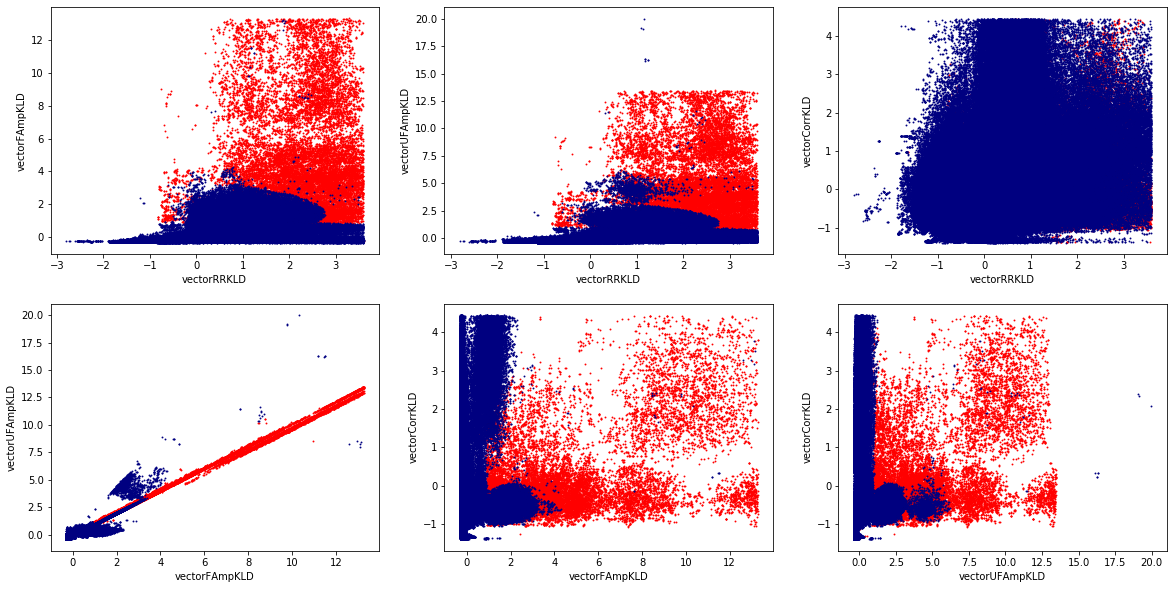

In [17]:
%matplotlib inline 
dp.plotAll2DGMMs(X, predicted, 1, 'red', titles)

----------------------------------------------------

### 3D MANIPULATION

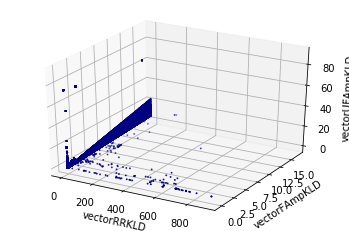

6091

In [20]:
# to show a dinamic view "%matplotlib notebook" , if not desired, use "%matplotlib inline"
%matplotlib inline 
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 0, 0, 1, 2, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

<IPython.core.display.Javascript object>


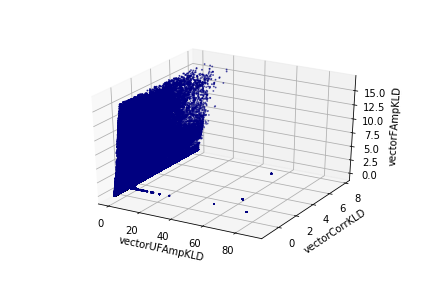

In [19]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 0, 2, 3, 1, 'red', titles)
plt.show(); #plt.clf(); plt.close(); gc.collect()

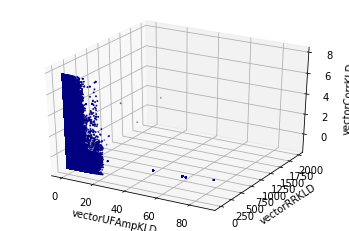

3061

In [35]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 1, 2, 0, 3, 'red', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

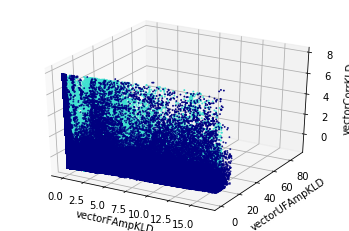

3293

In [24]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 2, 1, 2, 3, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

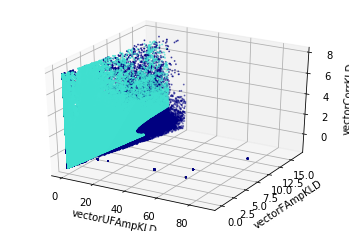

5621

In [29]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 2, 2, 1, 3, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

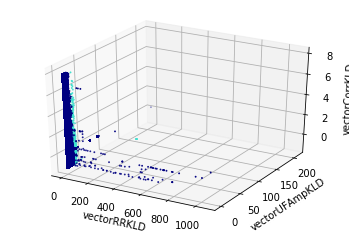

In [15]:
# to show a dinamic view "%matplotlib notebook" , if not desired, use "%matplotlib inline"
%matplotlib inline 
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 3, 0, 2, 3, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

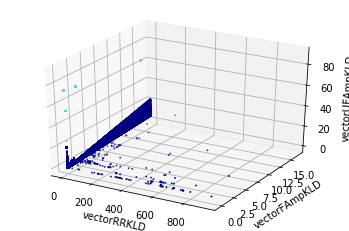

In [17]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 4, 0, 1, 2, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

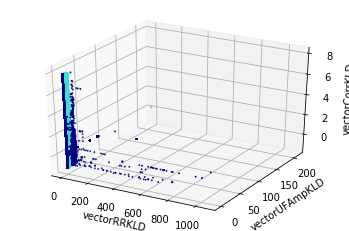

In [16]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 5, 0, 2, 3, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

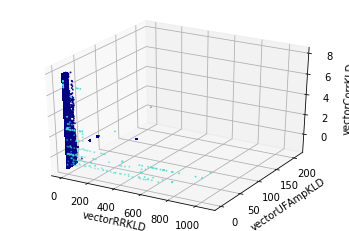

In [17]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 6, 0, 2, 3, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

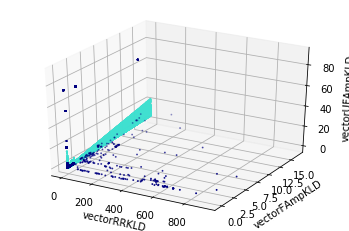

In [17]:
ax = plt.axes(projection='3d')
dp.plotOneGMMCluster3D(ax, X, predicted, 1, 0, 1, 2, 'turquoise', titles)
plt.show(); plt.clf(); plt.close(); gc.collect()

### Understand de BIC (Bayesian Information Criterion) Optional
> If runned, take into account the percentage of data from the total, for a 16Go computer it will only support 15% og the 120 million rows with 4 features in float32

In [ ]:
"""
n_components_range = range(5, 12)
best_gmm, bic, cv_types = cl.getBestGMMUsingBIC(X, n_components_range, ['full'], 0.1)
bic = np.array(bic)
color_iter = itertools.cycle(['navy', 'turquoise', 'cornflowerblue', 'darkorange', 'gold', 'tomato', 'crimson', 'darkslategray', 'springgreen', 'chocolate'])
dp.plotBICScores(bic, cv_types, color_iter, n_components_range)
"""